# Autoencoder

This is a 4 layers Autoencoder(2 encoder + 2 decoder) for performing dimensionality reduction on the GEFCOM-2014 load forecasting data

In [1]:
import numpy as np
import pandas as pd
from datetime import date, timedelta, datetime
import os
import pickle
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import Variable
from matplotlib.pyplot import figure

# Data Preprocessing & Staging

In [2]:
def get_data(file_name):
    data = pd.read_csv(file_name)
    data = data.to_numpy()
    for i in range(data.shape[0]):
        data[i, 1] = datetime.strptime(data[i, 1], "%m%d%Y %H:%M").date()
    power = data[:, 2].astype(np.float64)
    indexes = np.isnan(power)
    cleaned_data = data[~indexes, :]
    return cleaned_data

def embed_data(lead_time, embed_dim, from_date, to_date, data, t_idx, dt_idx):
    start = np.where(data[:, dt_idx] == from_date)[0][0]
    end = np.where(data[:, dt_idx] == to_date)[0][-1]
    X, y = [], []
    for idx in range(start, end+1):
        xx = data[idx-(embed_dim+lead_time-1):idx-lead_time+1, 3:]
        yy = data[idx, 2]
        X.append(xx)
        y.append(yy)
    return np.array(X), np.array(y)

def get_data_between_time(data, from_date, to_date, dt_idx):
    start = np.where(data[:, dt_idx] == from_date)[0][0]
    end = np.where(data[:, dt_idx] == to_date)[0][-1]
    return data[start:(end+1), :]


def normalize(data):
    for i in range(2, data.shape[1]):
        data[:, i] = (data[:, i] - np.mean(data[:, i]))/np.std(data[:, i])
    return data

In [3]:
data = get_data('./data/task_1/L1-train.csv')
data = normalize(data)
embedded_data, target = embed_data(
    lead_time = 6,
    embed_dim = 12,
    from_date = date(month=2, year=2005, day=1),
    to_date = date(month=4, year=2005, day=30),
    data = data,
    t_idx = 2,
    dt_idx = 1
)

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, down_size):
        super().__init__()
        self.input_size = input_size
        self.down_size = down_size
        
        self.factor = input_size / down_size
        self.encoded_size = self.down_size
        
        self.factor_root = np.sqrt(self.factor)
        self.first_squash = int(input_size / self.factor_root)
        
        self.linear_encode1 = nn.Linear(self.input_size, self.first_squash)
        self.linear_encode2 = nn.Linear(self.first_squash, self.encoded_size)
        
        self.linear_decode1 = nn.Linear(self.encoded_size, self.first_squash)
        self.linear_decode2 = nn.Linear(self.first_squash, self.input_size)
        
        # Activation
        self.first_squash_fn = nn.ELU()
        self.encode_fn = nn.Sigmoid()
        
    def forward(self, xx, decode = True, no_act = False):
        if no_act:
            xx = self.linear_encode1(xx)
            xx = self.linear_encode2(xx)

            if decode : 
                xx = self.linear_decode1(xx)
                xx = self.linear_decode2(xx) 
        else:
            xx = self.first_squash_fn( self.linear_encode1(xx) )
            xx = self.encode_fn(self.linear_encode2(xx))

            if decode : 
                xx = self.encode_fn(self.linear_decode1(xx))
                xx = self.first_squash_fn( self.linear_decode2(xx) )   
                
        return xx
    
    def train(self, data, batch_size, epochs = 30, lr = 0.01, no_act = False):
        learning_rate = 0.01
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr = lr)
        losses = []
        # Train the model
        for epoch in range(epochs):  
            indices = torch.randperm(data.size()[0])
            data = data[indices, :]
            for i in range(0, data.size()[0], batch_size):
                xx = data[i: i + batch_size, :]
                outputs = self.forward(xx, no_act = no_act)
                optimizer.zero_grad()
                
                loss = criterion(outputs, xx)
                losses.append(loss.item())
                
                loss.backward()
                optimizer.step()
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
        return losses

In [5]:
ae_data = get_data_between_time(
    data = data,
    from_date = date(month=1, year=2005, day=1),
    to_date = date(month=12, year=2005, day=31),
    dt_idx=1
)

ae_data = Variable(torch.from_numpy(ae_data[:, 3:].astype(np.float32)))

autoencoder = Autoencoder(
    input_size = 25,
    down_size = 15
)

losses = autoencoder.train(
    data = ae_data, 
    batch_size = 20, 
    epochs = 200, 
    lr = 0.000005,
    no_act = True
)

Epoch: 0, loss: 2.04887
Epoch: 1, loss: 0.83923
Epoch: 2, loss: 0.86279
Epoch: 3, loss: 1.11668
Epoch: 4, loss: 1.22677
Epoch: 5, loss: 0.97758
Epoch: 6, loss: 1.00468
Epoch: 7, loss: 0.83951
Epoch: 8, loss: 0.76218
Epoch: 9, loss: 0.79687
Epoch: 10, loss: 0.50523
Epoch: 11, loss: 0.51925
Epoch: 12, loss: 0.27909
Epoch: 13, loss: 0.28311
Epoch: 14, loss: 0.29743
Epoch: 15, loss: 0.18651
Epoch: 16, loss: 0.19835
Epoch: 17, loss: 0.12060
Epoch: 18, loss: 0.12082
Epoch: 19, loss: 0.10203
Epoch: 20, loss: 0.08288
Epoch: 21, loss: 0.07893
Epoch: 22, loss: 0.08627
Epoch: 23, loss: 0.07653
Epoch: 24, loss: 0.06090
Epoch: 25, loss: 0.07626
Epoch: 26, loss: 0.06360
Epoch: 27, loss: 0.06889
Epoch: 28, loss: 0.04645
Epoch: 29, loss: 0.05339
Epoch: 30, loss: 0.04172
Epoch: 31, loss: 0.04448
Epoch: 32, loss: 0.06722
Epoch: 33, loss: 0.07082
Epoch: 34, loss: 0.05694
Epoch: 35, loss: 0.04748
Epoch: 36, loss: 0.04246
Epoch: 37, loss: 0.04428
Epoch: 38, loss: 0.05345
Epoch: 39, loss: 0.04726
Epoch: 40,

In [69]:
# torch.save(autoencoder.state_dict(), './data/autoencoder_params')

# new_autoencoder = Autoencoder(
#     input_size = 25,
#     down_size = 15
# )

# new_autoencoder.load_state_dict(torch.load('./data/autoencoder_params'))

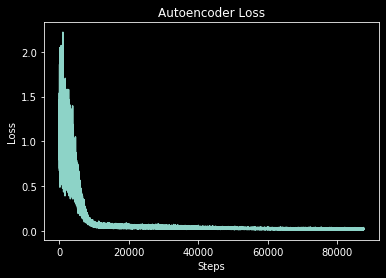

In [6]:
plt.plot(losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Autoencoder Loss')
plt.show()

## New Reduced Data

In [7]:
dataTensor = Variable(torch.from_numpy(data[:, 3:].astype(np.float32)))
encoded_data_without_date = autoencoder.forward(dataTensor, decode=False, no_act=True).detach().numpy()
encoded_data = np.concatenate((data[:, :3], encoded_data_without_date), axis=1)
embedded_encoded_data, target = embed_data(
    lead_time = 6,
    embed_dim = 12,
    from_date = date(month=1, year=2006, day=1),
    to_date = date(month=3, year=2006, day=31),
    data = encoded_data,
    t_idx = 2,
    dt_idx = 1
)

# LSTM for forecasting

In [30]:
class QuantileRegression(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, seq_length, alpha):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.num_layers = num_layers
        self.alpha = alpha
        
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size,
                            num_layers=num_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 10)
        self.fc_out = nn.Linear(10, output_size)
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        batch_size = x.size(0)
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(batch_size*self.num_layers, self.hidden_size)
#         print(ula.size(), h_out.size())
#         h_out = h_out.view(-1, self.hidden_size)
        
#         ula = ula.contiguous().view(x.size(0),-1)
        
        fc1 = self.fc(h_out)
        out = self.fc_out(fc1)
        
        return out
    
    def train_model(self, trainX, trainY, lr, epochs, sample_size, verbose=True):
        learning_rate = lr
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        losses = []
        num_epochs = epochs
        
        for epoch in range(num_epochs):  
            indices = torch.randperm(trainX.size()[0])
            trainX, trainY = trainX[indices, :, :], trainY[indices]
            for i in range(0, trainX.size()[0], sample_size):
                xx = trainX[i: i + sample_size, :, :]
                yy = trainY[i: i + sample_size]
                outputs = self.forward(xx)
                outputs = outputs.view(self.num_layers, self.output_size, -1)
                optimizer.zero_grad()
                alpha = self.alpha
                # obtain the loss function
                loss = self.quantile_loss(outputs[-1, :, :], yy, alpha)
                losses.append(loss.item())
                loss.backward()

                optimizer.step()
            if verbose:
                print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
            
        return losses
    
    def train_sgd(self, trainX, trainY, lr, epochs, sample_size):
        learning_rate = lr
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        losses = []
        num_epochs = epochs
        for epoch in range(num_epochs):
            for xx, yy in zip(trainX, trainY):
                xx = xx.view(1, self.seq_length, self.input_size)
                outputs = self.forward(xx)
                optimizer.zero_grad()

                # obtain the loss function
                loss = self.quantile_loss(outputs, yy, alpha=0.9)
                losses.append(loss)
                loss.backward()

                optimizer.step()
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
        return losses
    
    def quantile_loss(self, output, target, alpha):
        covered_flag = (output <= target).float()
        uncovered_flag = (output > target).float()
        return torch.mean((target - output)*(alpha)*covered_flag + (output-target)*(1-alpha)*uncovered_flag)

In [34]:
regressor = QuantileRegression(
    input_size = 25,
    hidden_size = 40,
    output_size = 1,
    num_layers = 1,
    seq_length = 12
)

train_x = embedded_data.astype(np.float32)
train_y = target.astype(np.float32)



trainX = Variable(torch.from_numpy(train_x))
trainY = Variable(torch.from_numpy(train_y))

losses = regressor.train_model(
    trainX = trainX,
    trainY = trainY,
    lr = 0.005,
    epochs = 40,
    sample_size = 50
)

Epoch: 0, loss: 0.06753
Epoch: 1, loss: 0.07151
Epoch: 2, loss: 0.06893
Epoch: 3, loss: 0.07654
Epoch: 4, loss: 0.07183
Epoch: 5, loss: 0.07165
Epoch: 6, loss: 0.05299
Epoch: 7, loss: 0.06551
Epoch: 8, loss: 0.06360
Epoch: 9, loss: 0.07248
Epoch: 10, loss: 0.04441
Epoch: 11, loss: 0.06539
Epoch: 12, loss: 0.05606
Epoch: 13, loss: 0.04395
Epoch: 14, loss: 0.06047
Epoch: 15, loss: 0.06226
Epoch: 16, loss: 0.06568
Epoch: 17, loss: 0.04134
Epoch: 18, loss: 0.06348
Epoch: 19, loss: 0.03546
Epoch: 20, loss: 0.05471
Epoch: 21, loss: 0.04289
Epoch: 22, loss: 0.03082
Epoch: 23, loss: 0.04215
Epoch: 24, loss: 0.04732
Epoch: 25, loss: 0.04203
Epoch: 26, loss: 0.05457
Epoch: 27, loss: 0.04112
Epoch: 28, loss: 0.04082
Epoch: 29, loss: 0.03881
Epoch: 30, loss: 0.02982
Epoch: 31, loss: 0.03808
Epoch: 32, loss: 0.04097
Epoch: 33, loss: 0.06221
Epoch: 34, loss: 0.03773
Epoch: 35, loss: 0.03817
Epoch: 36, loss: 0.03955
Epoch: 37, loss: 0.04813
Epoch: 38, loss: 0.03421
Epoch: 39, loss: 0.03972


(2136, 1) (2136,)


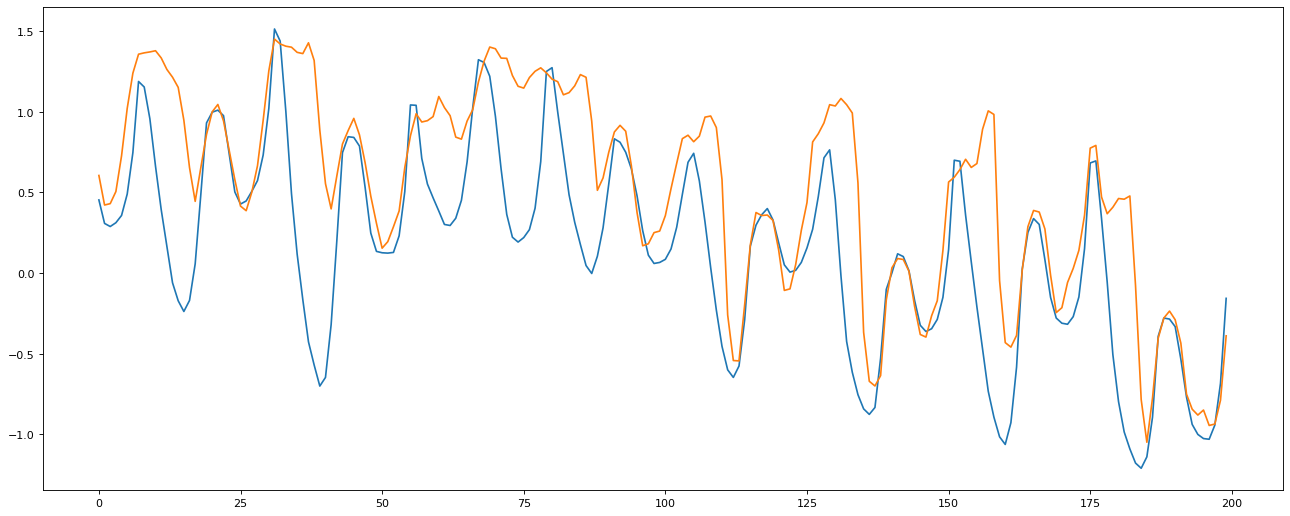

In [35]:
regressor.eval()
train_predict = regressor(trainX)
data_predict = train_predict.data.numpy()
dataY_plot =  trainY.data.numpy()
print(data_predict.shape, dataY_plot.shape)

figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
layers  = 1
from_here = int(data_predict.shape[0] / layers)
plt.plot(dataY_plot[:200])
plt.plot(data_predict[:200])

# Performance Check post Dimensionality Reduction

In [29]:
train_data_reduced, train_target_reduced = embed_data(
    lead_time = 6,
    embed_dim = 12,
    from_date = date(month=2, year=2006, day=1),
    to_date = date(month=4, year=2006, day=30),
    data = encoded_data,
    t_idx = 2,
    dt_idx = 1
)


regressor_reduced_dim = QuantileRegression(
    input_size=15,
    output_size=1,
    hidden_size=40,
    num_layers=1,
    seq_length=12,
    alpha=0.9
)

train_x = train_data_reduced.astype(np.float32)
train_y = train_target_reduced.astype(np.float32)

trainX = Variable(torch.from_numpy(train_x))
trainY = Variable(torch.from_numpy(train_y))

losses = regressor_reduced_dim.train_model(
    trainX = trainX,
    trainY = trainY,
    lr = 0.005,
    epochs = 100,
    sample_size = 50
)

Epoch: 0, loss: 0.08161
Epoch: 1, loss: 0.09219
Epoch: 2, loss: 0.09074
Epoch: 3, loss: 0.07029
Epoch: 4, loss: 0.08543
Epoch: 5, loss: 0.07958
Epoch: 6, loss: 0.06803
Epoch: 7, loss: 0.05920
Epoch: 8, loss: 0.08996
Epoch: 9, loss: 0.06670
Epoch: 10, loss: 0.06374
Epoch: 11, loss: 0.07435
Epoch: 12, loss: 0.05890
Epoch: 13, loss: 0.05176
Epoch: 14, loss: 0.07154
Epoch: 15, loss: 0.06894
Epoch: 16, loss: 0.06932
Epoch: 17, loss: 0.05470
Epoch: 18, loss: 0.05087
Epoch: 19, loss: 0.05738
Epoch: 20, loss: 0.06306
Epoch: 21, loss: 0.06141
Epoch: 22, loss: 0.06610
Epoch: 23, loss: 0.03595
Epoch: 24, loss: 0.05869
Epoch: 25, loss: 0.04841
Epoch: 26, loss: 0.03789
Epoch: 27, loss: 0.04994
Epoch: 28, loss: 0.04656
Epoch: 29, loss: 0.06158
Epoch: 30, loss: 0.04585
Epoch: 31, loss: 0.03381
Epoch: 32, loss: 0.04225
Epoch: 33, loss: 0.06837
Epoch: 34, loss: 0.04755
Epoch: 35, loss: 0.03059
Epoch: 36, loss: 0.04222
Epoch: 37, loss: 0.03136
Epoch: 38, loss: 0.07335
Epoch: 39, loss: 0.03907
Epoch: 40,

In [17]:
train_data_original, train_target_original = embed_data(
    lead_time = 6,
    embed_dim = 12,
    from_date = date(month=2, year=2006, day=1),
    to_date = date(month=4, year=2006, day=30),
    data = data,
    t_idx = 2,
    dt_idx = 1
)

regressor_original_dim = QuantileRegression(
    input_size=25,
    output_size=1,
    hidden_size=40,
    num_layers=1,
    seq_length=12,
    alpha = 0.9
)

train_x = train_data_original.astype(np.float32)
train_y = train_target_original.astype(np.float32)

trainX = Variable(torch.from_numpy(train_x))
trainY = Variable(torch.from_numpy(train_y))

losses = regressor_original_dim.train_model(
    trainX = trainX,
    trainY = trainY,
    lr = 0.005,
    epochs = 100,
    sample_size = 50
)

Epoch: 0, loss: 0.13868
Epoch: 1, loss: 0.08184
Epoch: 2, loss: 0.06572
Epoch: 3, loss: 0.08723
Epoch: 4, loss: 0.05587
Epoch: 5, loss: 0.07812
Epoch: 6, loss: 0.07572
Epoch: 7, loss: 0.06123
Epoch: 8, loss: 0.07044
Epoch: 9, loss: 0.05608
Epoch: 10, loss: 0.05683
Epoch: 11, loss: 0.05834
Epoch: 12, loss: 0.07401
Epoch: 13, loss: 0.05261
Epoch: 14, loss: 0.05599
Epoch: 15, loss: 0.03550
Epoch: 16, loss: 0.05769
Epoch: 17, loss: 0.03406
Epoch: 18, loss: 0.06185
Epoch: 19, loss: 0.04064
Epoch: 20, loss: 0.04627
Epoch: 21, loss: 0.05243
Epoch: 22, loss: 0.04528
Epoch: 23, loss: 0.04948
Epoch: 24, loss: 0.04865
Epoch: 25, loss: 0.03461
Epoch: 26, loss: 0.05655
Epoch: 27, loss: 0.03738
Epoch: 28, loss: 0.04119
Epoch: 29, loss: 0.05274
Epoch: 30, loss: 0.04544
Epoch: 31, loss: 0.03035
Epoch: 32, loss: 0.03804
Epoch: 33, loss: 0.03420
Epoch: 34, loss: 0.04254
Epoch: 35, loss: 0.06395
Epoch: 36, loss: 0.04200
Epoch: 37, loss: 0.04186
Epoch: 38, loss: 0.02692
Epoch: 39, loss: 0.02945
Epoch: 40,

## Prepare the Test Data

In [22]:
embedded_data_test, target_test = embed_data(
    lead_time = 6,
    embed_dim = 12,
    from_date = date(month=5, year=2006, day=1),
    to_date = date(month=6, year=2006, day=30),
    data = data,
    t_idx = 2,
    dt_idx = 1
)
test_x_original = embedded_data_test.astype(np.float32)
test_y_original = target_test.astype(np.float32)

testXOriginal = Variable(torch.from_numpy(test_x_original))

embedded_encoded_data_test, target_test = embed_data(
    lead_time = 6,
    embed_dim = 12,
    from_date = date(month=5, year=2006, day=1),
    to_date = date(month=6, year=2006, day=30),
    data = encoded_data,
    t_idx = 2,
    dt_idx = 1
)

test_x_reduced = embedded_encoded_data_test.astype(np.float32)
test_y_reduced = target_test.astype(np.float32)

testXReduced = Variable(torch.from_numpy(test_x_reduced))

## Assess the performance

In [23]:
regressor_original_dim.eval()
testYOriginalPredict = regressor_original_dim(testXOriginal)
test_pred_original = testYOriginalPredict.data.numpy()

regressor_reduced_dim.eval()
testYReducedPredict = regressor_reduced_dim(testXReduced)
test_pred_reduced = testYReducedPredict.data.numpy()

In [24]:
def quantile_loss(output, target, alpha):
    covered_flag = (output <= target).astype(np.float32)
    uncovered_flag = (output > target).astype(np.float32)
    return np.mean((target - output)*(alpha)*covered_flag + (output-target)*(1-alpha)*uncovered_flag)

In [27]:
print(quantile_loss(test_pred_original, test_y_original, alpha=0.9))
print(quantile_loss(test_pred_reduced, test_y_reduced, alpha=0.9))

0.5212829
0.57340497


In [33]:
alphas = [0.2, 0.4, 0.6, 0.8]

trainX_original = Variable(torch.from_numpy(train_data_original.astype(np.float32)))
trainX_reduced = Variable(torch.from_numpy(train_data_reduced.astype(np.float32)))
trainY = Variable(torch.from_numpy(train_target_reduced.astype(np.float32)))

for alpha in alphas:
    
    regressor_original_dim = QuantileRegression(
        input_size=25,
        output_size=1,
        hidden_size=40,
        num_layers=1,
        seq_length=12,
        alpha = alpha
    )

    regressor_reduced_dim = QuantileRegression(
        input_size=15,
        output_size=1,
        hidden_size=40,
        num_layers=1,
        seq_length=12,
        alpha=alpha
    )

    losses = regressor_original_dim.train_model(
        trainX = trainX_original,
        trainY = trainY,
        lr = 0.005,
        epochs = 100,
        sample_size = 50,
        verbose=False
    )

    losses = regressor_reduced_dim.train_model(
        trainX = trainX_reduced,
        trainY = trainY,
        lr = 0.005,
        epochs = 100,
        sample_size = 50,
        verbose=False
    )

    regressor_original_dim.eval()
    testYOriginalPredict = regressor_original_dim(testXOriginal)
    test_pred_original = testYOriginalPredict.data.numpy()

    regressor_reduced_dim.eval()
    testYReducedPredict = regressor_reduced_dim(testXReduced)
    test_pred_reduced = testYReducedPredict.data.numpy()

    print('These are the losses before and after dimensionality reduction to 15 variables')
    print('Before : ', quantile_loss(test_pred_original, test_y_original, alpha=alpha))
    print('After : ', quantile_loss(test_pred_reduced, test_y_reduced, alpha=alpha))
    




















    

These are the losses before and after dimensionality reduction to 15 variables
Before :  0.23846292
After :  0.24288389
These are the losses before and after dimensionality reduction to 15 variables
Before :  0.33736917
After :  0.34018245
These are the losses before and after dimensionality reduction to 15 variables
Before :  0.41538566
After :  0.4352617
These are the losses before and after dimensionality reduction to 15 variables
Before :  0.51759917
After :  0.50569123
